# Following is the data organization process

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)


import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(6,4))

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

In [2]:
#读取数据
nh3 = pd.read_excel('./Supplementary.xlsx', sheet_name=1)


In [3]:
#将分类变量、数值变量名称分隔开，便于后续数据处理
col_used = nh3.columns[6:]
col_categorical = ['Fertilizer type', 'Nitrogen placement', 'Soil tillage practices', 'Crop type']
col_numerical = list(set(col_used)-set(col_categorical))


In [4]:
#现将分类变量进行热码处理，然后再拼接上数值型变量，顺序不能变
df1 = pd.get_dummies(nh3[col_categorical]).astype(np.int64)
df1[col_numerical] = nh3[col_numerical]


In [5]:
#处理施肥次数作为肥料管理策略实施的依据    
df1['Fertilizer application time'] = [1 if x >= 2 else 0 for x in df1['Fertilizer application time']]


In [6]:
#简化变量名称
new_names = {'Fertilizer type_AN': 'Ftype(AN)',
             'Fertilizer type_EEF, controlled-release fertilizers': 'Ftype(CRF)',
             'Fertilizer type_EEF, double inhibitors': 'Ftype(DI)',
             'Fertilizer type_EEF, double inhibitors and controlled-release fertilizers': 'Ftype(DICR)',
             'Fertilizer type_EEF, nitrification inhibitors': 'Ftype(NI)',
             'Fertilizer type_EEF, urease inhibitors': 'Ftype(UI)',
             'Fertilizer type_Manure': 'Ftype(Manure)',
             'Fertilizer type_Others': 'Ftype(Others)',
             'Fertilizer type_U': 'Ftype(U)',
             'Nitrogen placement_DPM': 'NP(DPM)',
             'Nitrogen placement_Mix': 'NP(Mix)',
             'Nitrogen placement_SBC': 'NP(SBC)',
             'Soil tillage practices_CT': 'STP(CT)',
             'Soil tillage practices_NT': 'STP(NT)',
             'Crop type_Maize': 'Ctype(Maize)',
             'Crop type_Rice': 'Ctype(Rice)',
             'Crop type_Wheat': 'Ctype(Wheat)',
             'Fertilizer application time': 'FAT',
             'CEC': 'CEC',
             'Clay': 'Clay',
             'pH': 'pH',
             'TN': 'TN',
             'BD': 'BD',
             'Erate': 'Erate',
             'Erate_0': 'Erate_0',
             'SOC': 'SOC',
             'Water input': 'Water input',
             'Nrate': 'Nrate',
             'Tem': 'Tem',
             'EF': 'EF',
             'Replicates': 'Replicates'}

df1.rename(columns=new_names, inplace=True)

In [7]:
#将管理的5种化肥合成1种

df1['Ftype(EEF)'] = df1[['Ftype(CRF)', 'Ftype(DI)', 'Ftype(DICR)', 'Ftype(NI)','Ftype(UI)']].sum(axis=1)

In [8]:
#将目标变量进行BOX-COX变换使其接近正态分布
from sklearn import preprocessing
pt = preprocessing.PowerTransformer(method='box-cox', standardize=False)
df1['EFs'] = pt.fit_transform(100*df1['EF'].to_numpy().reshape(-1, 1)) #将数据整理成1列 

In [9]:
#查看BOX-COX变换中的参数lambda
pt.lambdas_[0]

0.28235436790951435

In [10]:
#随机打乱样本顺序
import sklearn
df = sklearn.utils.shuffle(df1, random_state=2022)  #随机排列整理好的数据

In [11]:
#获取特征变量和目标变量
Y = df['EFs'].values.reshape(len(df),1)
X = df.drop(['EFs', 'Erate', 'EF', 'Erate_0',  'Replicates',  'Ftype(CRF)', 'Ftype(DI)', 'Ftype(DICR)', 'Ftype(NI)','Ftype(UI)'], axis=1)

In [12]:
#划分训练集和测试集
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=2022, shuffle=False)

In [13]:
#储存训练集数据
df_train_save = pd.DataFrame([], index=x_train.index)
df_train_save['EFs'] = y_train.ravel()
for name in x_train.columns:
    df_train_save[name] = x_train[name]

df_train_save.to_excel('train_set(3.19).xlsx', index=False)

In [14]:
#储存测试集数据
df_test_save = pd.DataFrame([], index=x_test.index)
df_test_save['EFs'] = y_test.ravel()
for name in x_test.columns:
    df_test_save[name] = x_test[name]

df_test_save.to_excel('test_set(3.19).xlsx', index=False)

In [15]:
#储存整个数据
df_train_save = pd.DataFrame([], index=X.index)

df_train_save['EFs'] = Y.ravel()
for name in X.columns:
    df_train_save[name] = X[name]

df_train_save.to_excel('all(3.19).xlsx', index=False)

# 1.Following is the first method：RandomForest Regression Model

In [16]:
#设置初始参数
n_estimators = range(100,101)
# n_estimators = [30,50,100,150]
random_state = range(2023,2024)
max_features = range(1,X.shape[1])
min_samples_leaf = range(1,5)
max_depth = [3, 5, 8, 10, 15, 20, 25, 30, 35, 40, None] 

In [17]:
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'random_state': random_state,
              'min_samples_leaf': min_samples_leaf,
              'max_depth': max_depth}

In [18]:
#设置随机森林模型结构
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
grid = GridSearchCV(RandomForestRegressor(), 
                    param_grid, cv=10, n_jobs=-1, 
                    return_train_score=False)

In [19]:
#计时
from time import *
begin_time = time()

In [20]:
#拟合随机森林模型
grid.fit(x_train, y_train.ravel())

GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 8, 10, 15, 20, 25, 30, 35, 40,
                                       None],
                         'max_features': range(1, 23),
                         'min_samples_leaf': range(1, 5),
                         'n_estimators': range(100, 101),
                         'random_state': range(2023, 2024)})

In [21]:
# # 保存和加载随机森林回归模型
# from joblib import dump, load
# # 保存模型
# dump(grid, 'random_forest_model.joblib')
# # 加载模型
# grid = load('random_forest_model.joblib')
# # 使用加载的模型进行预测
# predictions = grid.predict(X_test)

In [22]:
#计算程序运行时间
end_time = time()
run_time = end_time-begin_time
print('time cost：',run_time/60, 'min') 

time cost： 0.42148407697677615 min


In [23]:
#获取最优随机森林模型参数
print('模型参数：', grid.best_params_)
# print('交叉验证结果：', grid.cv_results_)
print('测试集和训练集得分：', grid.score(x_test, y_test), grid.score(x_train, y_train))

模型参数： {'max_depth': 20, 'max_features': 10, 'min_samples_leaf': 1, 'n_estimators': 100, 'random_state': 2023}
测试集和训练集得分： 0.8204235831578783 0.9470598945727304


In [24]:
#模型预测
y_pred_train = grid.predict(x_train)
y_pred_test = grid.predict(x_test)

In [25]:
# #BOX-COX逆变换
# y_pred_train = pt.inverse_transform(y_pred_train.reshape(-1, 1))
# y_pred_test = pt.inverse_transform(y_pred_test.reshape(-1, 1))

# y_train = pt.inverse_transform(y_train)
# y_test = pt.inverse_transform(y_test )

In [26]:
#模型评估
from sklearn.metrics import mean_squared_error, r2_score
mse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
mse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print("训练集和测试集的均方误差分别为：", round(mse_train,2), round(mse_test,2))
print("训练集和测试集的可决系数分别为：", round(r2_train,2), round(r2_test,2))

训练集和测试集的均方误差分别为： 0.44 0.84
训练集和测试集的可决系数分别为： 0.95 0.82


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei


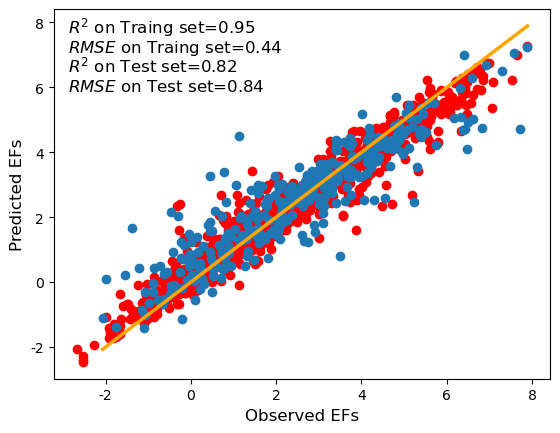

In [27]:
#绘图

colors = 'r'
plt.scatter(y_train, y_pred_train, c=colors, label='Traing set'+' (n='+str(len(y_train))+')')
plt.scatter(y_test, y_pred_test, label='Test set'+' (n='+str(len(y_test))+')')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linewidth=2.5 , c="orange")

plt.text(min(y_test)-0.8, max(max(y_test),max(y_pred_test))-0.2, '$R^{2}$ on Traing set='+str(round(r2_train,2)), fontsize=12)
plt.text(min(y_test)-0.8, max(max(y_test),max(y_pred_test))-0.8, '$RMSE$ on Traing set='+str(round(mse_train,2)), fontsize=12)
plt.text(min(y_test)-0.8, max(max(y_test),max(y_pred_test))-1.4, '$R^{2}$ on Test set='+str(round(r2_test,2)), fontsize=12)
plt.text(min(y_test)-0.8, max(max(y_test),max(y_pred_test))-2, '$RMSE$ on Test set='+str(round(mse_test,2)), fontsize=12)

#plt.legend(loc='lower right', edgecolor='black',fontsize=12)
# 坐标轴
plt.xlabel('Observed EFs', fontsize=12)
plt.ylabel('Predicted EFs', fontsize=12)
#plt.title('RandomForest Regression', fontsize=12)

plt.savefig('./结果汇总/RandomForest_regression.svg')

plt.show()

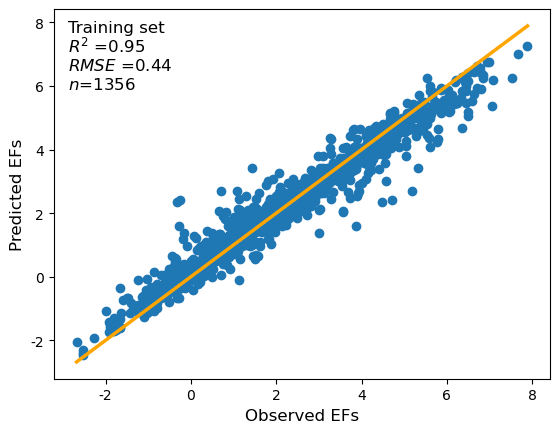

In [28]:

plt.scatter(y_train, y_pred_train, label='Training set'+' (n='+str(len(y_train))+')')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], linewidth=2.5 , c="orange")

plt.text(min(y_train)-0.2, max(max(y_train),max(y_pred_train))-0.2, 'Training set', fontsize=12)
plt.text(min(y_train)-0.2, max(max(y_train),max(y_pred_train))-0.8, '$R^{2}$ ='+str(round(r2_train,2)), fontsize=12)
plt.text(min(y_train)-0.2, max(max(y_train),max(y_pred_train))-1.4, '$RMSE$ ='+str(round(mse_train,2)), fontsize=12)
plt.text(min(y_train)-0.2, max(max(y_train),max(y_pred_train))-2, '$n$='+str(len(y_train)), fontsize=12)

#plt.legend(loc='lower right', edgecolor='black',fontsize=12)
plt.xlabel('Observed EFs', fontsize=12)
plt.ylabel('Predicted EFs', fontsize=12)
#plt.title('RandomForest Regression', fontsize=12)

plt.savefig('./结果汇总/RandomForest_Regression_training.svg')

plt.show()


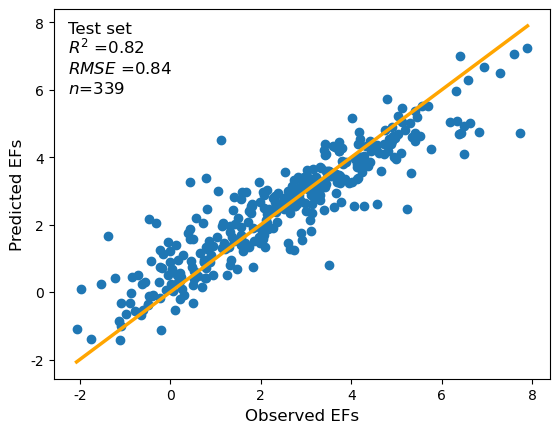

In [29]:
plt.scatter(y_test, y_pred_test, label='Test set'+' (n='+str(len(y_test))+')')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linewidth=2.5 , c="orange")

plt.text(min(y_test)-0.2, max(max(y_test),max(y_pred_test))-0.2, 'Test set', fontsize=12)
plt.text(min(y_test)-0.2, max(max(y_test),max(y_pred_test))-0.8, '$R^{2}$ ='+str(round(r2_test,2)), fontsize=12)
plt.text(min(y_test)-0.2, max(max(y_test),max(y_pred_test))-1.4, '$RMSE$ ='+str(round(mse_test,2)), fontsize=12)
plt.text(min(y_test)-0.2, max(max(y_test),max(y_pred_test))-2, '$n$='+str(len(y_test)), fontsize=12)

#plt.legend(loc='lower right', edgecolor='black',fontsize=12)
plt.xlabel('Observed EFs', fontsize=12)
plt.ylabel('Predicted EFs', fontsize=12)
#plt.title('RandomForest Regression', fontsize=12)

plt.savefig('./结果汇总/RandomForest_Regression_test.svg')

plt.show()


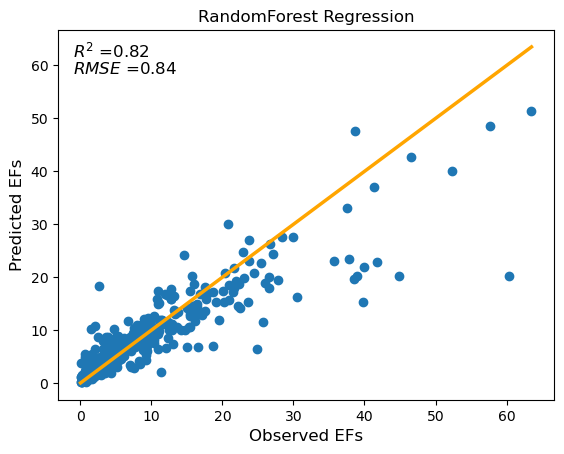

In [30]:
#应用Box-Cox逆变换进行EF值还原
EF_test = pt.inverse_transform(y_test.reshape(-1, 1)).ravel()
EF_pred_test = pt.inverse_transform(y_pred_test.reshape(-1, 1)).ravel()


plt.scatter(EF_test, EF_pred_test, label='Test set'+' (n='+str(len(EF_test))+')')
plt.plot([min(EF_test), max(EF_test)], [min(EF_test), max(EF_test)], linewidth=2.5 , c="orange")

plt.text(min(EF_test)-1, max(max(EF_test),max(EF_pred_test))-2, '$R^{2}$ ='+str(round(r2_test,2)), fontsize=12)
plt.text(min(EF_test)-1, max(max(EF_test),max(EF_pred_test))-5, '$RMSE$ ='+str(round(mse_test,2)), fontsize=12)

#plt.legend(loc='lower right', edgecolor='black',fontsize=12)
plt.xlabel('Observed EFs', fontsize=12)
plt.ylabel('Predicted EFs', fontsize=12)
plt.title('RandomForest Regression', fontsize=12)

plt.savefig('./结果汇总/RandomForest_Regression_test(EF).svg')

plt.show()


In [31]:
# 查看训练集上最优模型的袋外数据得分
RF = RandomForestRegressor(n_estimators=grid.best_params_['n_estimators'], 
                           max_features=grid.best_params_['max_features'], 
                           min_samples_leaf = grid.best_params_['min_samples_leaf'],
                           max_depth = grid.best_params_['max_depth'],
                           random_state=grid.best_params_['random_state'],
                           oob_score = True, 
                           n_jobs=14)

RF.fit(x_train, y_train.ravel())
print('袋外数据可决系数:', RF.oob_score_)

袋外数据可决系数: 0.7609867504071797


In [32]:
#应用训练集上的模型评估整体数据上的效果
from sklearn.model_selection import cross_val_score
scores = cross_val_score(RF, X, Y.ravel(), cv=10)
print('模型整体得分：', scores.mean())

模型整体得分： 0.7989283473081908


In [33]:
# #目标方程输出
# for i,feature in enumerate(X.columns):
#     print('{}*{}+'.format(grid.best_estimator_.feature_importances_[i], feature), end=' ')

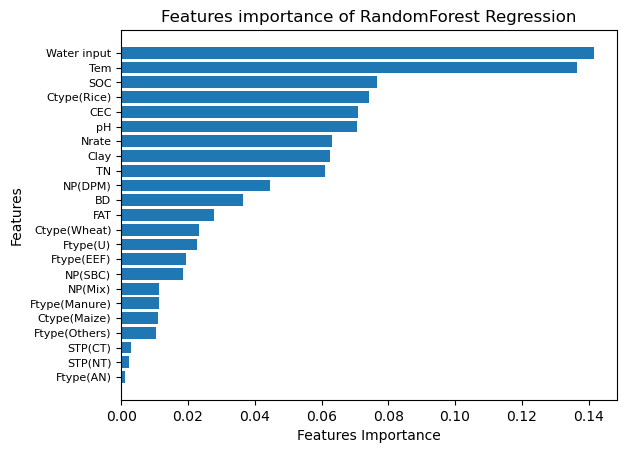

In [35]:
#控制显示结果
np.set_printoptions(suppress=True)   
pd.set_option('display.float_format', lambda x: '%.5f' % x) 
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

from matplotlib.mathtext import _mathtext as mathtext
mathtext.FontConstantsBase.sup1 = 0.3

#绘制特征重要性条形图
feature_importance = grid.best_estimator_.feature_importances_
feature_names = grid.best_estimator_.feature_names_in_
sorted_idx = feature_importance.argsort()

plt.barh(range(len(feature_importance)), feature_importance[sorted_idx])
plt.yticks(range(len(feature_importance)), [feature_names[i] for i in sorted_idx], fontsize=8)

plt.xlabel('Features Importance')
plt.ylabel('Features')
plt.title('Features importance of RandomForest Regression')

plt.savefig('./结果汇总/RandomForest_Regression_features_importance.svg')
plt.show()

### 合并训练集和测试集数据并对比中国和非中国的$NH_{3}$预测效果

In [36]:
#合并训练集和测试集数据，并用最优随机森林参数重新训练得到最终模型
RF1 = RandomForestRegressor(**grid.best_params_, oob_score = True)
RF1.fit(X, Y.ravel())

print('整体得分:', RF1.score(X, Y.ravel()))
print('整体袋外数据可决系数:', round(RF1.oob_score_,2))

整体得分: 0.9512286942706247
整体袋外数据可决系数: 0.8


In [37]:
EFs_pred = RF1.predict(X)

r2 = r2_score(Y, EFs_pred)
mse = np.sqrt(mean_squared_error(Y, EFs_pred))

print("整体的可决系数：", round(r2,2))
print("整体的均方误差为：", round(mse,2))

整体的可决系数： 0.95
整体的均方误差为： 0.43


In [38]:
## 将df['EF']的预测值进行Box-Cox逆变换
EF_pred = pt.inverse_transform(EFs_pred.reshape(-1, 1)).ravel()

In [39]:
## 将所EFs和EF的预测值极其真实值合并
save_dfs = pd.DataFrame({'EFs_pred':EFs_pred, 'EF_pred':EF_pred}, index=X.index)
save_df = pd.concat([df['EFs'], df['EF'], save_dfs], axis=1)
save_df['Region'] = sklearn.utils.shuffle(nh3['Region'], random_state=2022)
save_df.head()

,EFs,EF,EFs_pred,EF_pred,Region
473,5.56868,0.28395,5.35678,26.12409,中国
1387,3.42112,0.10958,3.31568,10.38186,中国
1595,4.91825,0.21843,4.61071,19.15812,阿根廷
702,4.44479,0.17813,4.20902,16.01896,中国
1228,4.79178,0.20708,4.69349,19.85600,中国


In [40]:
col_graph = ['EFs', 'EFs_pred', 'Region']
graph_df = save_df[col_graph]

graph_df1 = graph_df.loc[graph_df['Region']=='中国']
graph_df2 = graph_df.loc[graph_df['Region']!='中国']

In [41]:
r21 = r2_score(graph_df1['EFs'], graph_df1['EFs_pred'])
mse1 = np.sqrt(mean_squared_error(graph_df1['EFs'], graph_df1['EFs_pred']))

print("可决系数(中国)：", round(r21,4))
print("均方误差为(中国)：", round(mse1,4))

可决系数(中国)： 0.9483
均方误差为(中国)： 0.4244


In [42]:
r22 = r2_score(graph_df2['EFs'], graph_df2['EFs_pred'])
mse2 = np.sqrt(mean_squared_error(graph_df2['EFs'], graph_df2['EFs_pred']))

print("可决系数(非中国)：", round(r22,4))
print("均方误差为(非中国)：", round(mse2,4))

可决系数(非中国)： 0.9613
均方误差为(非中国)： 0.4598


In [43]:
rr = r2_score(graph_df['EFs'], graph_df['EFs_pred'])
msee = np.sqrt(mean_squared_error(graph_df['EFs'], graph_df['EFs_pred']))

print("整体的可决系数：", round(rr,4))
print("整体的均方误差为：", round(msee,4))

整体的可决系数： 0.9512
整体的均方误差为： 0.4288


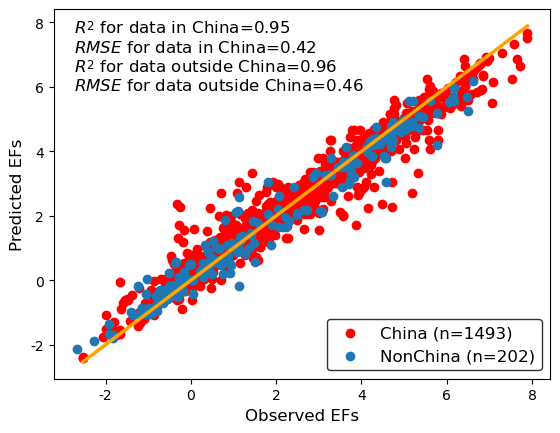

In [44]:
#绘图

colors = 'r'
plt.scatter(graph_df1['EFs'], graph_df1['EFs_pred'], c=colors, label='China'+' (n='+str(len(graph_df1))+')')
plt.scatter(graph_df2['EFs'], graph_df2['EFs_pred'], label='NonChina'+' (n='+str(len(graph_df2))+')')
# plt.scatter(graph_df1['EFs'], graph_df1['EFs_pred'], c=colors, label='China')
# plt.scatter(graph_df2['EFs'], graph_df2['EFs_pred'], label='NonChina')
plt.plot([min(graph_df1['EFs']), max(graph_df1['EFs'])], [min(graph_df1['EFs']), max(graph_df1['EFs'])], linewidth=2.5 , c="orange")

plt.text(min(graph_df1['EFs'])-0.2, max(max(graph_df1['EFs']),max(graph_df1['EFs_pred']))-0.2, '$R^{2}$ for data in China='+str(round(r21,2)), fontsize=12)
plt.text(min(graph_df1['EFs'])-0.2, max(max(graph_df1['EFs']),max(graph_df1['EFs_pred']))-0.8, '$RMSE$ for data in China='+str(round(mse1,2)), fontsize=12)
plt.text(min(graph_df1['EFs'])-0.2, max(max(graph_df1['EFs']),max(graph_df1['EFs_pred']))-1.4, '$R^{2}$ for data outside China='+str(round(r22,2)), fontsize=12)
plt.text(min(graph_df1['EFs'])-0.2, max(max(graph_df1['EFs']),max(graph_df1['EFs_pred']))-2, '$RMSE$ for data outside China='+str(round(mse2,2)), fontsize=12)

plt.legend(loc='lower right', edgecolor='black',fontsize=12)
# 坐标轴
plt.xlabel('Observed EFs', fontsize=12)
plt.ylabel('Predicted EFs', fontsize=12)

plt.savefig('./结果汇总/China_NonChina.svg')

plt.show()

# 2.Following is the second method：Ridge Regression Model

In [45]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [46]:
# 先对特征变量进行Z归一化处理
scaled_train = x_train
scaled_test = x_test

col_normalized = list(set(col_numerical)-set(['Fertilizer application time', 'EF', 'Erate', 'Replicates', 'Erate_0']))

scaler = StandardScaler()
scaled_train[col_normalized] = scaler.fit_transform(scaled_train[col_normalized])
scaled_test[col_normalized] = scaler.transform(scaled_test[col_normalized])

In [47]:
#储存训练集数据(Z标准化后)
scaled_train_save = pd.DataFrame([], index=scaled_train.index)
scaled_train_save['EF'] = y_train.ravel()
for name in scaled_train.columns:
    scaled_train_save[name] = scaled_train[name]

scaled_train_save.to_csv('scaled_train_set.csv', index=False)

In [48]:
#储存训练集数据(Z标准化后)
scaled_test_save = pd.DataFrame([], index=scaled_test.index)
scaled_test_save['EF'] = y_test.ravel()
for name in scaled_test.columns:
    scaled_test_save[name] = scaled_test[name]

scaled_test_save.to_excel('scaled_test_set.xlsx', index=False)

In [49]:
# 定义要搜索的alpha值范围
param_grid = {'alpha': np.logspace(-3, 2, 1000)}
ridge_search = GridSearchCV(Ridge(), param_grid, cv=10)
ridge_search.fit(scaled_train, y_train.ravel())

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': array([  0.001     ,   0.00101159,   0.00102332,   0.00103518,
         0.00104718,   0.00105931,   0.00107159,   0.00108401,
         0.00109658,   0.00110929,   0.00112215,   0.00113515,
         0.00114831,   0.00116162,   0.00117509,   0.00118871,
         0.00120249,   0.00121642,   0.00123052,   0.00124479,
         0.00125922,   0.00127381,   0.00128858,   0.00130351,
         0.00131862,   0.00133391,   0.001...
        69.95920165,  70.77010661,  71.59041086,  72.42022335,
        73.25965428,  74.10881516,  74.96781875,  75.83677915,
        76.71581177,  77.60503335,  78.504562  ,  79.41451719,
        80.33501977,  81.266192  ,  82.20815755,  83.16104153,
        84.1249705 ,  85.10007247,  86.08647696,  87.08431498,
        88.09371904,  89.11482323,  90.14776315,  91.19267598,
        92.24970053,  93.31897716,  94.40064789,  95.4948564 ,
        96.601748  ,  97.7214697 ,  98.85417022, 100.        ]

In [50]:
ridge = Ridge(**ridge_search.best_params_)
ridge.fit(scaled_train, y_train.ravel())

Ridge(alpha=21.102034285685967)

In [51]:
#模型预测
y_pred_train = ridge.predict(scaled_train)
y_pred_test = ridge.predict(scaled_test)

In [52]:
mse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
mse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

In [53]:
print("训练集和测试集的均方误差分别为：", round(mse_train,2), round(mse_test,2))
print("训练集和测试集的可决系数分别为：", round(r2_train,2), round(r2_test,2))

训练集和测试集的均方误差分别为： 1.62 1.67
训练集和测试集的可决系数分别为： 0.3 0.29


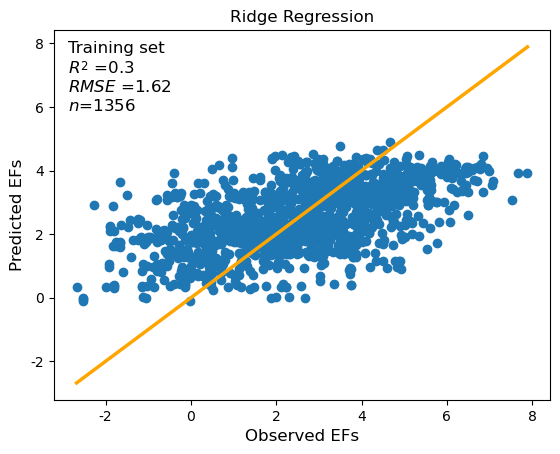

In [57]:
plt.scatter(y_train, y_pred_train, label='Training set'+' (n='+str(len(y_train))+')')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], linewidth=2.5 , c="orange")

plt.text(min(y_train)-0.2, max(max(y_train),max(y_pred_train))-0.2, 'Training set', fontsize=12)
plt.text(min(y_train)-0.2, max(max(y_train),max(y_pred_train))-0.8, '$R^{2}$ ='+str(round(r2_train,2)), fontsize=12)
plt.text(min(y_train)-0.2, max(max(y_train),max(y_pred_train))-1.4, '$RMSE$ ='+str(round(mse_train,2)), fontsize=12)
plt.text(min(y_train)-0.2, max(max(y_train),max(y_pred_train))-2, '$n$='+str(len(y_train)), fontsize=12)

#plt.legend(loc='lower right', edgecolor='black',fontsize=12)
plt.xlabel('Observed EFs', fontsize=12)
plt.ylabel('Predicted EFs', fontsize=12)
plt.title('Ridge Regression', fontsize=12)

plt.savefig('./结果汇总/Ridge_Regression_training.svg')

plt.show()

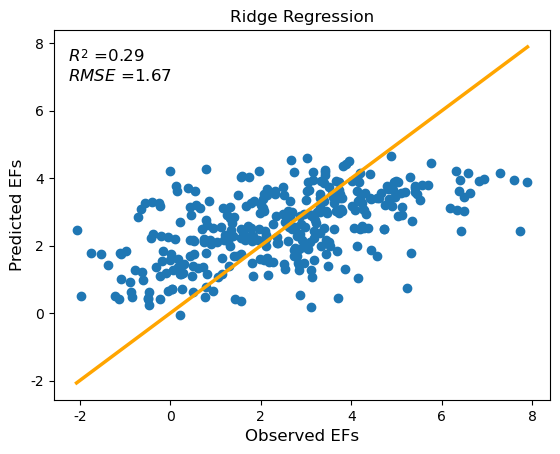

In [56]:
plt.scatter(y_test, y_pred_test, label='Test set'+' (n='+str(len(y_test))+')')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linewidth=2.5 , c="orange")

plt.text(min(y_test)-0.2, max(max(y_test),max(y_pred_test))-0.4, '$R^{2}$ ='+str(round(r2_test,2)), fontsize=12)
plt.text(min(y_test)-0.2, max(max(y_test),max(y_pred_test))-1, '$RMSE$ ='+str(round(mse_test,2)), fontsize=12)

#plt.legend(loc='lower right', edgecolor='black',fontsize=12)
# 坐标轴
plt.xlabel('Observed EFs', fontsize=12)
plt.ylabel('Predicted EFs', fontsize=12)
plt.title('Ridge Regression', fontsize=12)

plt.savefig('./结果汇总/Ridge_Regression_test.svg')

plt.show()

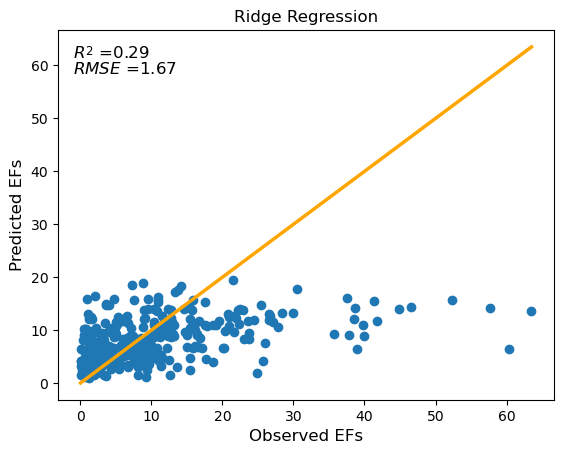

In [58]:
#应用Box-Cox逆变换进行EF值还原
EF_test = pt.inverse_transform(y_test.reshape(-1, 1)).ravel()
EF_pred_test = pt.inverse_transform(y_pred_test.reshape(-1, 1)).ravel()


plt.scatter(EF_test, EF_pred_test, label='Test set'+' (n='+str(len(EF_test))+')')
plt.plot([min(EF_test), max(EF_test)], [min(EF_test), max(EF_test)], linewidth=2.5 , c="orange")

plt.text(min(EF_test)-1, max(max(EF_test),max(EF_pred_test))-2, '$R^{2}$ ='+str(round(r2_test,2)), fontsize=12)
plt.text(min(EF_test)-1, max(max(EF_test),max(EF_pred_test))-5, '$RMSE$ ='+str(round(mse_test,2)), fontsize=12)

#plt.legend(loc='lower right', edgecolor='black',fontsize=12)
plt.xlabel('Observed EFs', fontsize=12)
plt.ylabel('Predicted EFs', fontsize=12)
plt.title('Ridge Regression', fontsize=12)

plt.savefig('./结果汇总/Ridge_Regression_test(EF).svg')

plt.show()


# 3.Following is the third method：SupportVector Regression Model

In [59]:
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [60]:
param_grid = {'C':np.logspace(-2, 2, 50), 'gamma':np.arange(0.05, 1, 20)}

# 创建SVR模型对象，这里使用径向基函数（RBF）核
grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=10, scoring='neg_mean_squared_error')
# 训练模型
grid_search.fit(scaled_train, y_train.ravel())

GridSearchCV(cv=10, estimator=SVR(),
             param_grid={'C': array([  0.01      ,   0.01206793,   0.01456348,   0.01757511,
         0.02120951,   0.02559548,   0.03088844,   0.03727594,
         0.04498433,   0.05428675,   0.06551286,   0.07906043,
         0.09540955,   0.11513954,   0.13894955,   0.16768329,
         0.20235896,   0.24420531,   0.29470517,   0.35564803,
         0.42919343,   0.51794747,   0.62505519,   0.75431201,
         0.91029818,   1.09854114,   1.32571137,   1.59985872,
         1.93069773,   2.32995181,   2.8117687 ,   3.39322177,
         4.09491506,   4.94171336,   5.96362332,   7.19685673,
         8.68511374,  10.48113134,  12.64855217,  15.26417967,
        18.42069969,  22.22996483,  26.82695795,  32.37457543,
        39.06939937,  47.14866363,  56.89866029,  68.6648845 ,
        82.86427729, 100.        ]),
                         'gamma': array([0.05])},
             scoring='neg_mean_squared_error')

In [61]:
svr_rbf = SVR(**grid_search.best_params_)
svr_rbf.fit(scaled_train, y_train.ravel())

SVR(C=100.0, gamma=0.05)

In [62]:
#模型预测
y_pred_train = svr_rbf.predict(scaled_train)
y_pred_test = svr_rbf.predict(scaled_test)

In [63]:
mse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
mse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

In [64]:
print("训练集和测试集的均方误差分别为：", round(mse_train,2), round(mse_test,2))
print("训练集和测试集的可决系数分别为：", round(r2_train,2), round(r2_test,2))

训练集和测试集的均方误差分别为： 0.69 1.0
训练集和测试集的可决系数分别为： 0.87 0.75


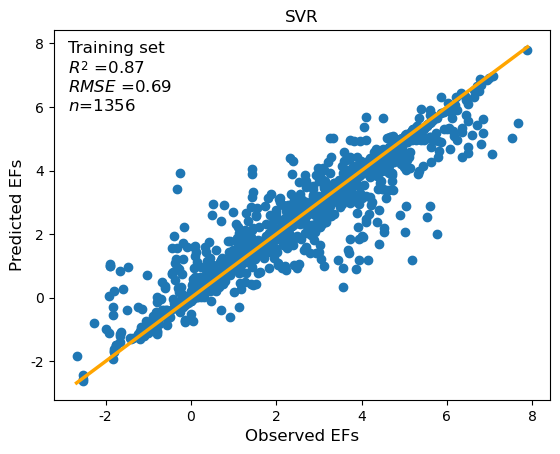

In [65]:
plt.scatter(y_train, y_pred_train, label='Training set'+' (n='+str(len(y_train))+')')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], linewidth=2.5 , c="orange")

plt.text(min(y_train)-0.2, max(max(y_train),max(y_pred_train))-0.2, 'Training set', fontsize=12)
plt.text(min(y_train)-0.2, max(max(y_train),max(y_pred_train))-0.8, '$R^{2}$ ='+str(round(r2_train,2)), fontsize=12)
plt.text(min(y_train)-0.2, max(max(y_train),max(y_pred_train))-1.4, '$RMSE$ ='+str(round(mse_train,2)), fontsize=12)
plt.text(min(y_train)-0.2, max(max(y_train),max(y_pred_train))-2, '$n$='+str(len(y_train)), fontsize=12)

#plt.legend(loc='lower right', edgecolor='black',fontsize=12)
plt.xlabel('Observed EFs', fontsize=12)
plt.ylabel('Predicted EFs', fontsize=12)
plt.title('SVR', fontsize=12)

plt.savefig('./结果汇总/SupportVector_Regression_training.svg')

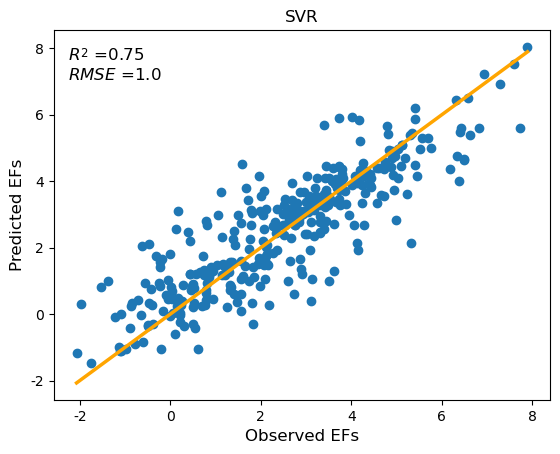

In [66]:

plt.scatter(y_test, y_pred_test, label='Test set'+' (n='+str(len(y_test))+')')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linewidth=2.5 , c="orange")

plt.text(min(y_test)-0.2, max(max(y_test),max(y_pred_test))-0.4, '$R^{2}$ ='+str(round(r2_test,2)), fontsize=12)
plt.text(min(y_test)-0.2, max(max(y_test),max(y_pred_test))-1, '$RMSE$ ='+str(round(mse_test,2)), fontsize=12)

#plt.legend(loc='lower right', edgecolor='black',fontsize=12)
plt.xlabel('Observed EFs', fontsize=12)
plt.ylabel('Predicted EFs', fontsize=12)
plt.title('SVR', fontsize=12)

plt.savefig('./结果汇总/SupportVector_Regression_test.svg')

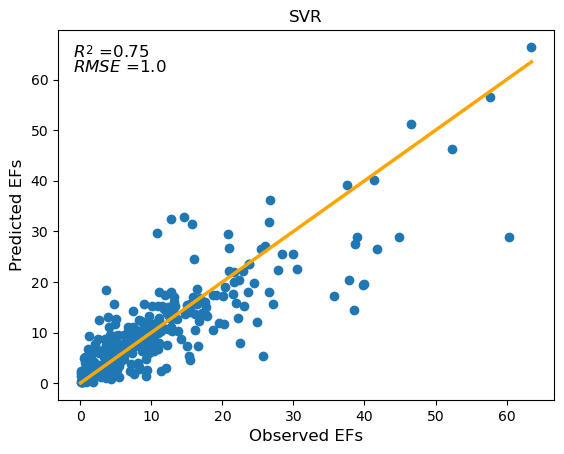

In [67]:
#应用Box-Cox逆变换进行EF值还原
EF_test = pt.inverse_transform(y_test.reshape(-1, 1)).ravel()
EF_pred_test = pt.inverse_transform(y_pred_test.reshape(-1, 1)).ravel()


plt.scatter(EF_test, EF_pred_test, label='Test set'+' (n='+str(len(EF_test))+')')
plt.plot([min(EF_test), max(EF_test)], [min(EF_test), max(EF_test)], linewidth=2.5 , c="orange")

plt.text(min(EF_test)-1, max(max(EF_test),max(EF_pred_test))-2, '$R^{2}$ ='+str(round(r2_test,2)), fontsize=12)
plt.text(min(EF_test)-1, max(max(EF_test),max(EF_pred_test))-5, '$RMSE$ ='+str(round(mse_test,2)), fontsize=12)

#plt.legend(loc='lower right', edgecolor='black',fontsize=12)
plt.xlabel('Observed EFs', fontsize=12)
plt.ylabel('Predicted EFs', fontsize=12)
plt.title('SVR', fontsize=12)

plt.savefig('./结果汇总/SupportVector_Regression(EF).svg')

plt.show()


# 4.Following is the third method：GradientBoostingDecisionTree Model

In [68]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from time import *

In [69]:
#计时
begin_time = time()

In [70]:
param_grid = {'learning_rate':np.logspace(-2, 0, 20), 'n_estimators':[50,100,150], 'max_depth':[3,5,10]}

# 创建GBDT模型
grid_search = GridSearchCV(GradientBoostingRegressor(), param_grid, cv=10)
grid_search.fit(scaled_train, y_train.ravel())

GridSearchCV(cv=10, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': array([0.01      , 0.01274275, 0.01623777, 0.02069138, 0.02636651,
       0.03359818, 0.04281332, 0.05455595, 0.06951928, 0.08858668,
       0.11288379, 0.14384499, 0.18329807, 0.23357215, 0.29763514,
       0.37926902, 0.48329302, 0.61584821, 0.78475997, 1.        ]),
                         'max_depth': [3, 5, 10],
                         'n_estimators': [50, 100, 150]})

In [71]:
#计算程序运行时间
end_time = time()
run_time = end_time-begin_time
print('time cost：',run_time/60, 'min')  

time cost： 8.710747412840526 min


In [72]:
DBDT = GradientBoostingRegressor(**grid_search.best_params_)
DBDT.fit(scaled_train, y_train.ravel())

GradientBoostingRegressor(learning_rate=0.11288378916846889, max_depth=5,
                          n_estimators=150)

In [73]:
#模型预测
y_pred_train = DBDT.predict(scaled_train)
y_pred_test = DBDT.predict(scaled_test)

In [74]:
mse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
mse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

In [75]:
print("训练集和测试集的均方误差分别为：", round(mse_train,2), round(mse_test,2))
print("训练集和测试集的可决系数分别为：", round(r2_train,2), round(r2_test,2))

训练集和测试集的均方误差分别为： 0.5 0.84
训练集和测试集的可决系数分别为： 0.93 0.82


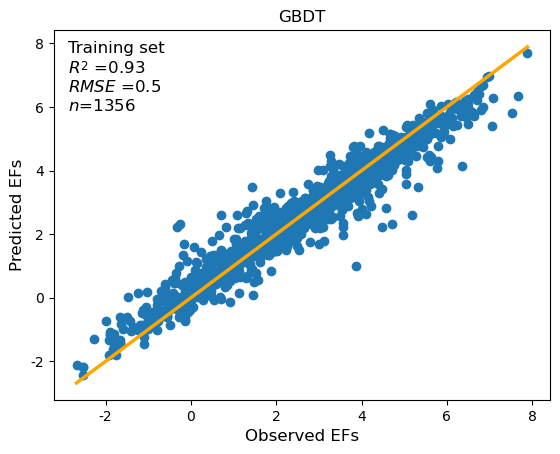

In [76]:
plt.scatter(y_train, y_pred_train, label='Training set'+' (n='+str(len(y_train))+')')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], linewidth=2.5 , c="orange")

plt.text(min(y_train)-0.2, max(max(y_train),max(y_pred_train))-0.2, 'Training set', fontsize=12)
plt.text(min(y_train)-0.2, max(max(y_train),max(y_pred_train))-0.8, '$R^{2}$ ='+str(round(r2_train,2)), fontsize=12)
plt.text(min(y_train)-0.2, max(max(y_train),max(y_pred_train))-1.4, '$RMSE$ ='+str(round(mse_train,2)), fontsize=12)
plt.text(min(y_train)-0.2, max(max(y_train),max(y_pred_train))-2, '$n$='+str(len(y_train)), fontsize=12)

#plt.legend(loc='lower right', edgecolor='black',fontsize=12)
plt.xlabel('Observed EFs', fontsize=12)
plt.ylabel('Predicted EFs', fontsize=12)
plt.title('GBDT', fontsize=12)

plt.savefig('./结果汇总/GBDT_Regression_training.svg')

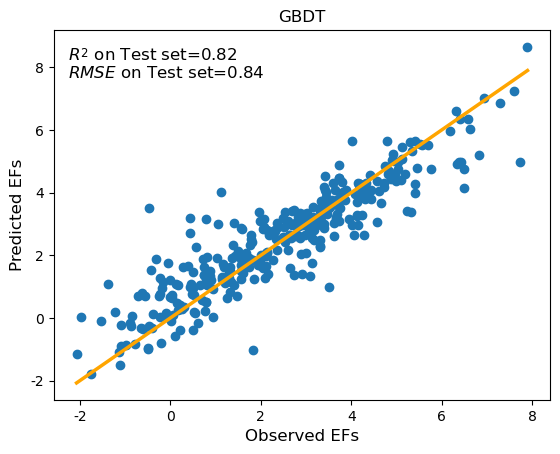

In [77]:
plt.scatter(y_test, y_pred_test, label='Test set'+' (n='+str(len(y_test))+')')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linewidth=2.5 , c="orange")

plt.text(min(y_test)-0.2, max(max(y_test),max(y_pred_test))-0.4, '$R^{2}$ on Test set='+str(round(r2_test,2)), fontsize=12)
plt.text(min(y_test)-0.2, max(max(y_test),max(y_pred_test))-1, '$RMSE$ on Test set='+str(round(mse_test,2)), fontsize=12)

#plt.legend(loc='lower right', edgecolor='black',fontsize=12)
plt.xlabel('Observed EFs', fontsize=12)
plt.ylabel('Predicted EFs', fontsize=12)
plt.title('GBDT', fontsize=12)

plt.savefig('./结果汇总/GBDT_Regression.svg')

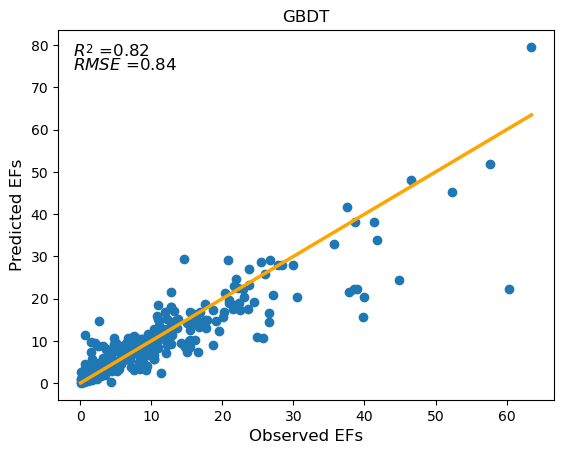

In [78]:
#应用Box-Cox逆变换进行EF值还原
EF_test = pt.inverse_transform(y_test.reshape(-1, 1)).ravel()
EF_pred_test = pt.inverse_transform(y_pred_test.reshape(-1, 1)).ravel()


plt.scatter(EF_test, EF_pred_test, label='Test set'+' (n='+str(len(EF_test))+')')
plt.plot([min(EF_test), max(EF_test)], [min(EF_test), max(EF_test)], linewidth=2.5 , c="orange")

plt.text(min(EF_test)-1, max(max(EF_test),max(EF_pred_test))-2, '$R^{2}$ ='+str(round(r2_test,2)), fontsize=12)
plt.text(min(EF_test)-1, max(max(EF_test),max(EF_pred_test))-5.5, '$RMSE$ ='+str(round(mse_test,2)), fontsize=12)

#plt.legend(loc='lower right', edgecolor='black',fontsize=12)
plt.xlabel('Observed EFs', fontsize=12)
plt.ylabel('Predicted EFs', fontsize=12)
plt.title('GBDT', fontsize=12)

plt.savefig('./结果汇总/GBDT_Regression(EF).svg')

plt.show()


# 5.Following is the fourth method：FeedforwardNeuralNetwork Model(Pytorch框架)

In [79]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [80]:
#转换为PyTorch张量
X_train_tensor = torch.FloatTensor(scaled_train.values)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
X_test_tensor = torch.FloatTensor(scaled_test.values)
y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)

In [81]:
#定义神经网络模型
class FNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(input_size, output_size)  #输入维度input_size，输出维度output_size
        self.fc2 = nn.Linear(output_size, int(0.5*output_size))
        self.fc3 = nn.Linear(int(0.5*output_size),int(0.25*output_size))
        self.fc4 = nn.Linear(int(0.25*output_size),int(0.125*output_size))
        self.fc5 = nn.Linear(int(0.125*output_size), 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return(x)

In [82]:
#实例化模型(定义损失函数和优化器)
model = FNN(scaled_train.shape[1], 64) #8的倍数
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [83]:
#训练模型
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()  # 清零梯度

    # 前向传播
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # 反向传播和优化
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 2.7173
Epoch [200/1000], Loss: 2.3280
Epoch [300/1000], Loss: 1.7671
Epoch [400/1000], Loss: 1.1043
Epoch [500/1000], Loss: 0.6593
Epoch [600/1000], Loss: 0.4730
Epoch [700/1000], Loss: 0.3685
Epoch [800/1000], Loss: 0.3231
Epoch [900/1000], Loss: 0.2907
Epoch [1000/1000], Loss: 0.2607


In [84]:
#评估模型
model.eval()
with torch.no_grad():    
    y_pred_train = model(X_train_tensor)
    y_pred_test = model(X_test_tensor)

mse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
mse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

In [85]:
print("训练集和测试集的均方误差分别为：", round(mse_train,2), round(mse_test,2))
print("训练集和测试集的可决系数分别为：", round(r2_train,2), round(r2_test,2))

训练集和测试集的均方误差分别为： 0.51 1.2
训练集和测试集的可决系数分别为： 0.93 0.63


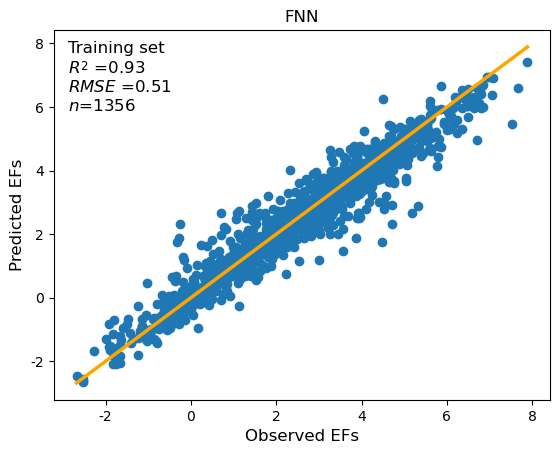

In [87]:
plt.scatter(y_train, y_pred_train, label='Training set'+' (n='+str(len(y_train))+')')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], linewidth=2.5 , c="orange")

plt.text(min(y_train)-0.2, max(max(y_train),max(y_pred_train.cpu().numpy()))-0.2, 'Training set', fontsize=12)
plt.text(min(y_train)-0.2, max(max(y_train),max(y_pred_train.cpu().numpy()))-0.8, '$R^{2}$ ='+str(round(r2_train,2)), fontsize=12)
plt.text(min(y_train)-0.2, max(max(y_train),max(y_pred_train.cpu().numpy()))-1.4, '$RMSE$ ='+str(round(mse_train,2)), fontsize=12)
plt.text(min(y_train)-0.2, max(max(y_train),max(y_pred_train.cpu().numpy()))-2, '$n$='+str(len(y_train)), fontsize=12)

#plt.legend(loc='lower right', edgecolor='black',fontsize=12)
plt.xlabel('Observed EFs', fontsize=12)
plt.ylabel('Predicted EFs', fontsize=12)
plt.title('FNN', fontsize=12)

plt.savefig('./结果汇总/FNN_Regression_training.svg')

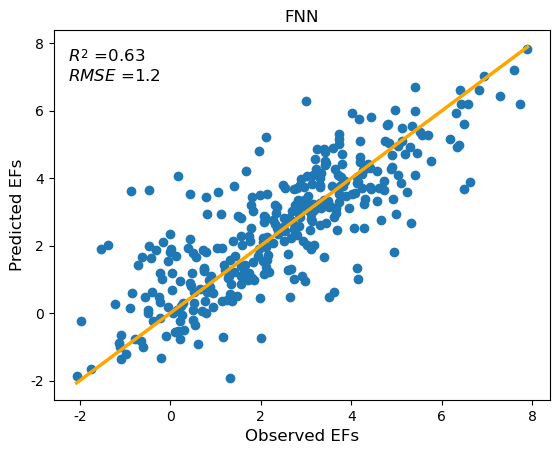

In [88]:

plt.scatter(y_test, y_pred_test, label='Test set'+' (n='+str(len(y_test))+')')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linewidth=2.5 , c="orange")

plt.text(min(y_test)-0.2, max(max(y_test),max(y_pred_test.cpu().numpy()))-0.4, '$R^{2}$ ='+str(round(r2_test,2)), fontsize=12)
plt.text(min(y_test)-0.2, max(max(y_test),max(y_pred_test.cpu().numpy()))-1, '$RMSE$ ='+str(round(mse_test,2)), fontsize=12)

#plt.legend(loc='lower right', edgecolor='black',fontsize=12)
#坐标轴
plt.xlabel('Observed EFs', fontsize=12)
plt.ylabel('Predicted EFs', fontsize=12)
plt.title('FNN', fontsize=12)

plt.savefig('./结果汇总/FNN_Regression.svg')

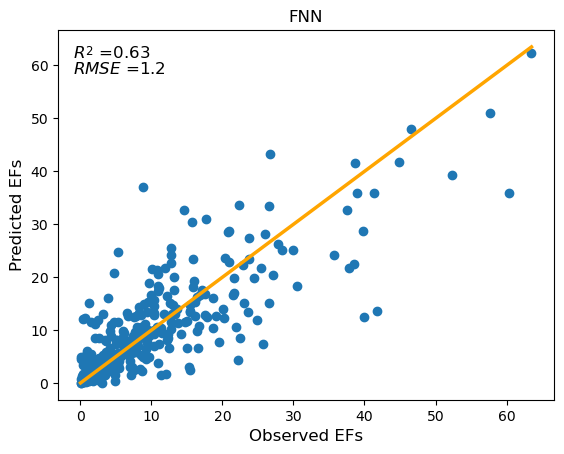

In [89]:
#应用Box-Cox逆变换进行EF值还原
EF_test = pt.inverse_transform(y_test.reshape(-1, 1)).ravel()
EF_pred_test = pt.inverse_transform(y_pred_test.reshape(-1, 1)).ravel()


plt.scatter(EF_test, EF_pred_test, label='Test set'+' (n='+str(len(EF_test))+')')
plt.plot([min(EF_test), max(EF_test)], [min(EF_test), max(EF_test)], linewidth=2.5 , c="orange")

plt.text(min(EF_test)-1, max(max(EF_test),max(EF_pred_test))-2, '$R^{2}$ ='+str(round(r2_test,2)), fontsize=12)
plt.text(min(EF_test)-1, max(max(EF_test),max(EF_pred_test))-5, '$RMSE$ ='+str(round(mse_test,2)), fontsize=12)

#plt.legend(loc='lower right', edgecolor='black',fontsize=12)
plt.xlabel('Observed EFs', fontsize=12)
plt.ylabel('Predicted EFs', fontsize=12)
plt.title('FNN', fontsize=12)

plt.savefig('./结果汇总/FNN_Regression(EF).svg')

plt.show()


# 6.Following is the fifth method：ResidualNetwork Model(Pytorch框架)

In [90]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [91]:
#转换为PyTorch张量
X_train_tensor = torch.FloatTensor(scaled_train.values)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
X_test_tensor = torch.FloatTensor(scaled_test.values)
y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)

In [92]:
#定义残差块
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, out_channels)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.fc2 = nn.Linear(out_channels, out_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.fc3 = nn.Linear(out_channels, out_channels)
        self.bn3 = nn.BatchNorm1d(out_channels)
        self.fc4 = nn.Linear(out_channels, out_channels)
        self.bn4 = nn.BatchNorm1d(out_channels)
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Linear(in_channels, out_channels)

    def forward(self, x):
        out = torch.relu(self.bn1(self.fc1(x)))
        out = self.bn2(self.fc2(out))
        out = self.bn3(self.fc2(out))
        out = self.bn4(self.fc2(out))
        out += self.shortcut(x)  # 添加残差
        out = torch.relu(out)
        return(out)

In [93]:
#定义ResNet模型
class ResNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(ResNet, self).__init__()
        self.layer1 = ResidualBlock(input_size, output_size)
        self.layer2 = ResidualBlock(output_size, int(0.5*output_size))  
        self.layer3 = ResidualBlock(int(0.5*output_size), int(0.25*output_size))
        self.layer4 = ResidualBlock(int(0.25*output_size), int(0.125*output_size))
        self.fc = nn.Linear(int(0.125*output_size), 1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.fc(out)
        return(out)

In [94]:
#实例化模型, 定义损失函数和优化器
model = ResNet(scaled_train.shape[1], 64)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [95]:
#训练模型
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()  # 清零梯度

    # 前向传播
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # 反向传播和优化
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 0.2043
Epoch [200/1000], Loss: 0.1567
Epoch [300/1000], Loss: 0.1422
Epoch [400/1000], Loss: 0.1375
Epoch [500/1000], Loss: 0.1360
Epoch [600/1000], Loss: 0.1244
Epoch [700/1000], Loss: 0.1184
Epoch [800/1000], Loss: 0.1217
Epoch [900/1000], Loss: 0.1215
Epoch [1000/1000], Loss: 0.1450


In [96]:
#评估模型
model.eval()
with torch.no_grad():    
    y_pred_train = model(X_train_tensor)
    y_pred_test = model(X_test_tensor)

In [97]:
mse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
mse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

In [98]:
print("训练集和测试集的均方误差分别为：", round(mse_train,2), round(mse_test,2))
print("训练集和测试集的可决系数分别为：", round(r2_train,2), round(r2_test,2))

训练集和测试集的均方误差分别为： 0.4 1.09
训练集和测试集的可决系数分别为： 0.96 0.7


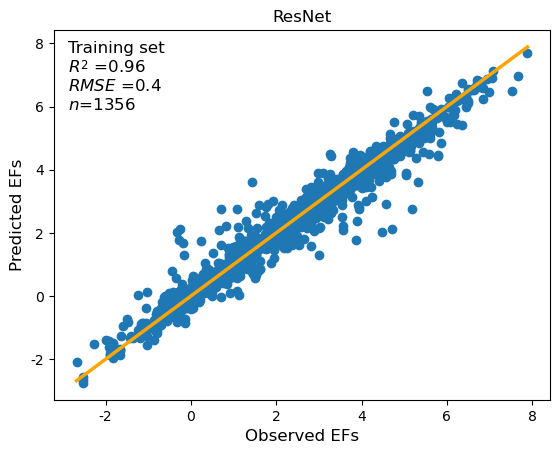

In [99]:

plt.scatter(y_train, y_pred_train, label='Training set'+' (n='+str(len(y_train))+')')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], linewidth=2.5 , c="orange")

plt.text(min(y_train)-0.2, max(max(y_train),max(y_pred_train.cpu().numpy()))-0.2, 'Training set', fontsize=12)
plt.text(min(y_train)-0.2, max(max(y_train),max(y_pred_train.cpu().numpy()))-0.8, '$R^{2}$ ='+str(round(r2_train,2)), fontsize=12)
plt.text(min(y_train)-0.2, max(max(y_train),max(y_pred_train.cpu().numpy()))-1.4, '$RMSE$ ='+str(round(mse_train,2)), fontsize=12)
plt.text(min(y_train)-0.2, max(max(y_train),max(y_pred_train.cpu().numpy()))-2, '$n$='+str(len(y_train)), fontsize=12)

#plt.legend(loc='lower right', edgecolor='black',fontsize=12)
plt.xlabel('Observed EFs', fontsize=12)
plt.ylabel('Predicted EFs', fontsize=12)

plt.title('ResNet', fontsize=12)
plt.savefig('./结果汇总/ResNet_Regression_training.svg')

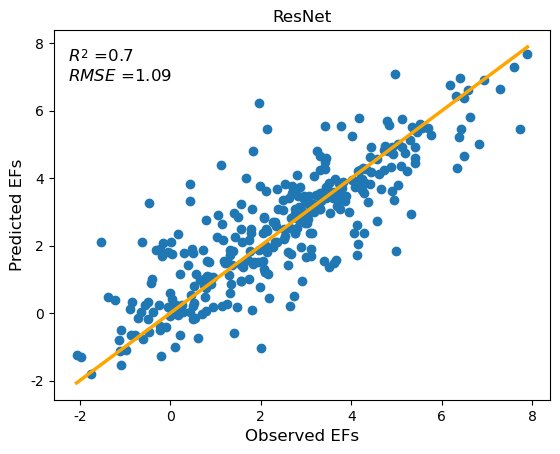

In [100]:

plt.scatter(y_test, y_pred_test, label='Test set'+' (n='+str(len(y_test))+')')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linewidth=2.5 , c="orange")

plt.text(min(y_test)-0.2, max(max(y_test),max(y_pred_test.cpu().numpy()))-0.4, '$R^{2}$ ='+str(round(r2_test,2)), fontsize=12)
plt.text(min(y_test)-0.2, max(max(y_test),max(y_pred_test.cpu().numpy()))-1, '$RMSE$ ='+str(round(mse_test,2)), fontsize=12)

#plt.legend(loc='lower right', edgecolor='black',fontsize=12)
plt.xlabel('Observed EFs', fontsize=12)
plt.ylabel('Predicted EFs', fontsize=12)
plt.title('ResNet', fontsize=12)

plt.savefig('./结果汇总/ResNet_Regression.svg')

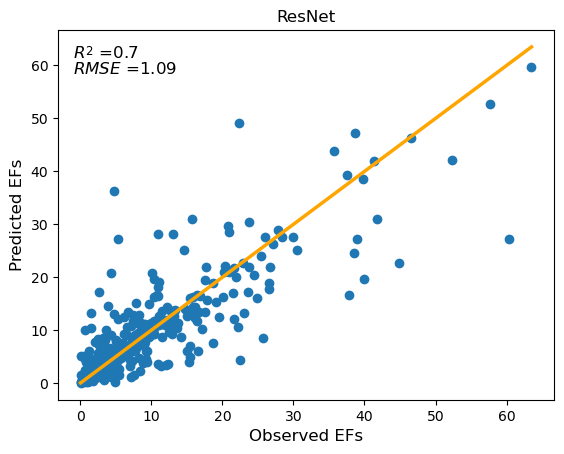

In [101]:
#应用Box-Cox逆变换进行EF值还原
EF_test = pt.inverse_transform(y_test.reshape(-1, 1)).ravel()
EF_pred_test = pt.inverse_transform(y_pred_test.reshape(-1, 1)).ravel()


plt.scatter(EF_test, EF_pred_test, label='Test set'+' (n='+str(len(EF_test))+')')
plt.plot([min(EF_test), max(EF_test)], [min(EF_test), max(EF_test)], linewidth=2.5 , c="orange")

plt.text(min(EF_test)-1, max(max(EF_test),max(EF_pred_test))-2, '$R^{2}$ ='+str(round(r2_test,2)), fontsize=12)
plt.text(min(EF_test)-1, max(max(EF_test),max(EF_pred_test))-5, '$RMSE$ ='+str(round(mse_test,2)), fontsize=12)

#plt.legend(loc='lower right', edgecolor='black',fontsize=12)
plt.xlabel('Observed EFs', fontsize=12)
plt.ylabel('Predicted EFs', fontsize=12)
plt.title('ResNet', fontsize=12)

plt.savefig('./结果汇总/ResNet_Regression(EF).svg')

plt.show()
